# 1. Initialisation

## 1.1. File System

In [1]:
from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
drive.mount("/content/drive")

! chmod -R 777 'drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article'

% cd 'drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article'

Mounted at /content/drive
/content/drive/My Drive/Otago/A. Work in Progress/H. Roadmap/Experiment/Semantically Embedded Humanitarian Space/Model 1 Full Article


## 1.2. Importing Libraries

In [2]:
# !pip install livelossplot
# !pip install pandas-profiling==2.7.1
# !pip uninstall -y h5py
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 15.7 MB 308 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
google-co

In [3]:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport

import time
import re
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
import csv
import ast
import pickle
import itertools
import random
from scipy.spatial import distance

In [4]:
%tensorflow_version 1.x
import tensorflow as tf
from keras import Model
from keras.backend.tensorflow_backend import set_session
import sklearn.metrics
from keras.preprocessing.sequence import pad_sequences

# from sklearn import preprocessing

# from keras.preprocessing.text import one_hot
# from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
# from keras import Input
# from keras.layers import Dense, Concatenate, BatchNormalization
# from keras.layers import Flatten, Dot
# from keras.layers import LSTM, GRU, Dropout
# from keras.layers import Lambda
# from keras.layers import Activation
# from keras.layers.embeddings import Embedding
import keras.backend as K
from keras.losses import mse

TensorFlow 1.x selected.


Using TensorFlow backend.


In [5]:
from keras.models import load_model

In [6]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [7]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
sys.path.insert(0, './Libraries')
import preprocess

## 1.3. GPU Initialisation

In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



## 1.4. Global Variables

In [10]:
# model_name = 'RIVEC300_'
model_name = 'RIVEC300_SMALL_'
max_word = 3500
num_ent = 100
alpha = -1.5

In [11]:
Use_Word2Vec = True

## 1.5. Model Reloading

In [12]:
def custom_loss_func(first_pos, second_pos):
    def custom_loss(y_true, y_pred):
        first_idx = K.argmax(K.abs(first_pos), axis = -1)
        second_idx = K.argmax(K.abs(second_pos), axis = -1)
        
        first_max = tf.gather(first_pos, first_idx, axis = 1)
        second_max = tf.gather(second_pos, second_idx, axis = 1)

        first_second = K.mean(mse(first_max, second_max)) * 0.1
        first_first = K.binary_crossentropy(y_true, y_pred)

        return mse(first_second, first_first)
    custom_loss.__name__ = 'custom_loss'
    return custom_loss

In [13]:
# if Use_Word2Vec:
#     word_vectors = KeyedVectors.load_word2vec_format('./Pretrained/GoogleNews-vectors-negative300.bin', binary=True)

In [14]:
# if Use_Word2Vec: w2v_ext = 'With_Word2Vec'
# else: w2v_ext = 'Without_Word2Vec'

In [15]:
modelInputFile = f'./Model/{model_name}SEmHus_Word_Embedding_Model.h5'
model = load_model(modelInputFile)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## 1.6. Tokenizers Reloading

In [16]:
with open(f'./Tokenizer/{model_name}text.pickle', 'rb') as handle:
    texts_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}actor.pickle', 'rb') as handle:
    labActor_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}agency.pickle', 'rb') as handle:
    labAgency_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}sector.pickle', 'rb') as handle:
    labSector_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}place.pickle', 'rb') as handle:
    labPlace_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}year.pickle', 'rb') as handle:
    labYear_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}month.pickle', 'rb') as handle:
    labMonth_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}reason.pickle', 'rb') as handle:
    labReason_tok = pickle.load(handle)

with open(f'./Tokenizer/{model_name}goal.pickle', 'rb') as handle:
    labGoal_tok = pickle.load(handle)

# 2. Data Preparation

In [17]:
def clean_alpha(text):
    text = ' '.join([w for w in str(text).split() if w.isalpha()])
    return text

## 2.1. Input and Output

In [18]:
# normInputFile = './Inputs/SEmHus_Enriched_Normalised_Dataset.csv'
normInputFile = f'./Inputs/{model_name}SEmHus_Enriched_Normalised_Dataset_Test.csv'
normDF = pd.read_csv(normInputFile)

In [19]:
normDF = normDF.loc[(normDF['country_name'] != "['World']") & (normDF['disaster_type'] != "['Other']") & (normDF['source_type'] != "['Media']")]

In [20]:
docs = normDF['text'].tolist()
labActor = [eval(v) for v in normDF['source_name'].tolist()]
labAgency = [eval(v) for v in normDF['source_type'].tolist()]
labSector = [eval(v) for v in normDF['theme'].tolist()]
labPlace = [eval(v) for v in normDF['country_name'].tolist()]
labYear = [eval(v) for v in normDF['year_created'].tolist()]
labMonth = [eval(v) for v in normDF['month_created'].tolist()]
labReason = [eval(v) for v in normDF['disaster_type'].tolist()]
labGoal = [eval(v) for v in normDF['development_goal'].tolist()]

In [21]:
# del normDF

In [22]:
labReason_tok.classes_

array(['Cold Wave', 'Drought', 'Earthquake', 'Epidemic',
       'Extratropical Cyclone', 'Fire', 'Flash Flood', 'Flood',
       'Heat Wave', 'Insect Infestation', 'Land Slide', 'Mud Slide',
       'Other', 'Severe Local Storm', 'Snow Avalanche', 'Storm Surge',
       'Technological Disaster', 'Tropical Cyclone', 'Tsunami', 'Volcano',
       'Wild Fire'], dtype=object)

In [23]:
# lbl_sec = labSector_tok.classes_.astype('U')
# np.savetxt('./Lists/sector_list.csv', lbl_sec, delimiter=',', fmt='%s')

In [24]:
# lbl_sec = labReason_tok.classes_.astype('U')
# np.savetxt('./Lists/reason_list.csv', lbl_sec, delimiter=',', fmt='%s')

In [25]:
docs = [' '.join(str(d).lower().split()[:max_word]) for d in docs]

In [26]:
len(labActor)

5280

In [27]:
padding_len = model.layers[0].get_output_at(0).get_shape().as_list()[1]

In [28]:
padding_len

100

## 2.2. Import Dictionaries

In [29]:
list_encoded_text = f'./Dictionary/{model_name}list_encoded_text.csv'
word_embed_dict = f'./Dictionary/{model_name}word_embed_dict.csv'

# 3. Class Embedding

## 3.1. Semantic Similarity Setup

In [30]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Vectors
# vec_a = [1, 2, 3, 4, 5]
# vec_b = [1, 3, 5, 7, 9]

# # Dot and norm
# dot = sum(a*b for a, b in zip(vec_a, vec_b))
# norm_a = sum(a*a for a in vec_a) ** 0.5
# norm_b = sum(b*b for b in vec_b) ** 0.5

# # Cosine similarity
# cos_sim = dot / (norm_a*norm_b)

# # Results
# print('My version:', cos_sim)
# print('Scikit-Learn:', cosine_similarity([vec_a], [vec_b]))

In [31]:
def cosine(vec1, vec2):
    vec1 = np.array(vec1).tolist()
    vec2 = np.array(vec2).tolist()
    dot = sum(a*b for a, b in zip(vec1, vec2))
    norm_a = sum(a*a for a in vec1) ** 0.5
    norm_b = sum(b*b for b in vec2) ** 0.5
    cos_sim = dot / (norm_a*norm_b)
    return cos_sim

In [32]:
# num_word = 20

In [33]:
agency_weight = model.get_layer('outAgency').get_weights()[0]
agency_transpose = np.asarray(np.transpose(agency_weight))
agency_embed = {w: agency_transpose[idx] for idx, w in enumerate(labAgency_tok.classes_)}

actor_weight = model.get_layer('outActor').get_weights()[0]
actor_transpose = np.asarray(np.transpose(actor_weight))
actor_embed = {w: actor_transpose[idx] for idx, w in enumerate(labActor_tok.classes_)}

goal_weight = model.get_layer('outGoal').get_weights()[0]
goal_transpose = np.asarray(np.transpose(goal_weight))
goal_embed = {w: goal_transpose[idx] for idx, w in enumerate(labGoal_tok.classes_)}

sector_weight = model.get_layer('outSector').get_weights()[0]
sector_transpose = np.asarray(np.transpose(sector_weight))
sector_embed = {w: sector_transpose[idx] for idx, w in enumerate(labSector_tok.classes_)}

place_weight = model.get_layer('outPlace').get_weights()[0]
place_transpose = np.asarray(np.transpose(place_weight))
place_embed = {w: place_transpose[idx] for idx, w in enumerate(labPlace_tok.classes_)}

year_weight = model.get_layer('outYear').get_weights()[0]
year_transpose = np.asarray(np.transpose(year_weight))
year_embed = {w: year_transpose[idx] for idx, w in enumerate(labYear_tok.classes_)}

month_weight = model.get_layer('outMonth').get_weights()[0]
month_transpose = np.asarray(np.transpose(month_weight))
month_embed = {w: month_transpose[idx] for idx, w in enumerate(labMonth_tok.classes_)}

reason_weight = model.get_layer('outReason').get_weights()[0]
reason_transpose = np.asarray(np.transpose(reason_weight))
reason_embed = {w: reason_transpose[idx] for idx, w in enumerate(labReason_tok.classes_)}

In [34]:
# def nearest_label(group, entity):
#     if group == '*':
#         new_df = class_df
#     else:
#         new_df = class_df.loc[class_df['Class'] == group]

#     vec1 = new_df.loc[class_df['Entity'] == entity]
#     vec1 = vec1.iloc[0]['Vector']
#     dist = []
#     # for cls, ent, vec2 in class_data:
#     for cls, ent, vec2 in class_df.values.tolist():
#         d = distance.cosine(vec1, vec2)
#         if d > 0:
#             dist.append((round(distance.cosine(vec1, vec2), 4), ent, cls))
#     dist.sort()
#     dist = dist[:20]
#     return dist

In [35]:
# def nearest_class(first, second, third, num_ent):
#     if first == 'Agency': class_list = agency_embed.items()
#     if first == 'Actor': class_list = actor_embed.items()
#     if first == 'Goal': class_list = goal_embed.items()
#     if first == 'Sector': class_list = sector_embed.items()
#     if first == 'Place': class_list = place_embed.items()
#     if first == 'Year': class_list = year_embed.items()
#     if first == 'Month': class_list = month_embed.items()
#     if first == 'Reason': class_list = reason_embed.items()

#     if second == 'Agency': vec1 = agency_embed[third]
#     if second == 'Actor': vec1 = actor_embed[third]
#     if second == 'Goal': vec1 = goal_embed[third]
#     if second == 'Sector': vec1 = sector_embed[third]
#     if second == 'Place': vec1 = place_embed[third]
#     if second == 'Year': vec1 = year_embed[third]
#     if second == 'Month': vec1 = month_embed[third]
#     if second == 'Reason': vec1 = reason_embed[third]

#     dist = []
#     for word, vec2 in class_list:
#         d = distance.cosine(vec1, vec2)
#         if d > 0:
#             #dist.append((np.linalg.norm(vec1 - vec2), word))
#             dist.append((round(d, 4), word))
#     dist.sort()
#     dist = dist[:num_ent]
#     return dist

## 3.2. Vector Space Export

In [36]:
def normalize(word_vec):
    norm=np.linalg.norm(word_vec)
    if norm == 0:
       return word_vec
    return word_vec/norm

In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [38]:
cols = ['Class', 'Entity', 'Vector', 'X', 'Y']
rows = []

ent = []
nam = []
vec = []

for key, value in agency_embed.items():
    ent.append('Agency')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in actor_embed.items():
    ent.append('Actor')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in goal_embed.items():
    ent.append('Goal')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in sector_embed.items():
    ent.append('Sector')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in place_embed.items():
    ent.append('Place')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in year_embed.items():
    ent.append('Year')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in month_embed.items():
    ent.append('Month')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

for key, value in reason_embed.items():
    ent.append('Reason')
    nam.append(key)
    normed = normalize(list(value))
    vec.append(normed)

reduced_vector = tsne.fit_transform(vec)
X_dim = reduced_vector[:,0]
Y_dim = reduced_vector[:,1]

In [39]:
rows = np.array([ent, nam, vec, X_dim, Y_dim])

rows_t = rows.T 

class_df = pd.DataFrame(data=rows_t, columns = cols)
class_df.to_csv(f'./Outputs/{model_name}Humanitarian_Class_Vector_Space.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [40]:
# class_data = class_df.values.tolist()

## 3.3. Entity Distance Export

In [41]:
file_name = f'./Outputs/{model_name}Humanitarian_Class_Distance_Space.csv'

if os.path.isfile(file_name):
    dist_df = pd.read_csv(file_name)
else:
    cols = ['Source_Class', 'Source_Entity', 'Target_Class', 'Target_Entity', 'Distance']
    rows = []

    for sidx, source in class_df.iterrows():
        for tidx, target in class_df.iterrows():

            if (source['Class'] == target['Class']) and (source['Entity'] == target['Entity']): continue
            
            # dist = distance.euclidean(source['Vector'], target['Vector'])
            dist = distance.cosine(source['Vector'], target['Vector'])
            rows.append([source['Class'], source['Entity'], target['Class'], target['Entity'], dist])

    dist_df = pd.DataFrame(data=rows, columns = cols)
    dist_df.to_csv(file_name)

In [42]:
# file_name = f'./Outputs/{model_name}Humanitarian_Class_Distance_Space.csv'

# cols = ['Source_Class', 'Source_Entity', 'Target_Class', 'Target_Entity', 'Distance']
# rows = []

# for sidx, source in class_df.iterrows():
#     for tidx, target in class_df.iterrows():

#         if (source['Class'] == target['Class']) and (source['Entity'] == target['Entity']): continue
        
#         # dist = distance.euclidean(source['Vector'], target['Vector'])
#         dist = distance.cosine(source['Vector'], target['Vector'])
#         rows.append([source['Class'], source['Entity'], target['Class'], target['Entity'], dist])

# dist_df = pd.DataFrame(data=rows, columns = cols)
# dist_df.to_csv(file_name)

In [43]:
def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [44]:
def nearest_class(first, second, third, near):

    class_list = dist_df[(dist_df['Source_Class'] == first) & (dist_df['Target_Class'] == second) & (dist_df['Target_Entity'] == third) ]

    dist = []

    # nam = []
    # dis = []

    for idx, row in class_list.iterrows():
        d = row[5]
        # d = row[4]
        if d > 0:
            #dist.append((np.linalg.norm(vec1 - vec2), word))
            dist.append((round(d, 4), row['Source_Entity']))
            # nam.append(row['Source_Entity'])
            # dis.append(d)
    
    # dis = normalize(dis)
    # dist = merge(dis, nam)
    
    dist.sort()
    dist = dist[:near]

    return dist

In [45]:
def farest_class(first, second, third, near):

    class_list = dist_df[(dist_df['Source_Class'] == first) & (dist_df['Target_Class'] == second) & (dist_df['Target_Entity'] == third) ]


    dist = []

    # nam = []
    # dis = []
    
    for idx, row in class_list.iterrows():
        d = row[5]
        # d = row[4]
        if d > 0:
            #dist.append((np.linalg.norm(vec1 - vec2), word))
            dist.append((round(d, 4), row['Source_Entity']))
            # nam.append(row['Source_Entity'])
            # dis.append(d)
    
    # dis = normalize(dis)
    # dist = merge(dis, nam)

    dist.sort()
    dist = dist[-near:]

    return dist

In [46]:
def find_stat(cls):
    if cls == '*':
        temp_df = dist_df[(dist_df['Distance'] > 0)]
    else:
        temp_df = dist_df[(dist_df['Source_Class'] == cls) & (dist_df['Distance'] > 0)]

    dist_lst = temp_df['Distance'].values

    sd = np.std(dist_lst)
    me = np.mean(dist_lst)
    mx = np.max(dist_lst)
    mn = np.min(dist_lst)
    cs = (mx - mn) / sd

    return sd, me, mx, mn, cs

In [47]:
def find_rank(cls, val, alpha):
    
    stat = find_stat(cls)
    
    stdev = stat[0]
    mean = stat[1]
    # measure = mean - (alpha * stdev)
    measure = (val - mean) / stdev

    # if alpha < measure: rank = 'Accepted'
    # if alpha >= measure: rank = 'Rejected'

    if alpha >= measure: rank = 'Accepted'
    if alpha < measure: rank = 'Rejected'

    return rank

In [48]:
# class_df = dist_df[(dist_df['Source_Class'] == 'Place') & (dist_df['Distance'] > 0)]
# # class_df = dist_df[(dist_df['Distance'] > 0)]

# dist_lst = class_df['Distance'].values

cls = '*'
stat = find_stat(cls)

print('Standard Deviation:', round(stat[0], 6))
print('Mean Distance:', round(stat[1], 6))
print('Maximum Distance:', round(stat[2], 6))
print('Minimum Distance :', round(stat[3], 6))
print('Number of CS :', round(stat[4], 6))

Standard Deviation: 0.093927
Mean Distance: 0.952101
Maximum Distance: 1.424574
Minimum Distance : 0.03174
Number of CS : 14.828827


# 4. Result Validation

In [49]:
# var1, var2 = 'Year', 'Year'

# if var2 == 'Agency': rand_class = labAgency_tok.classes_[random.randint(0, len(labAgency_tok.classes_)-1)]
# if var2 == 'Actor': rand_class = labActor_tok.classes_[random.randint(0, len(labActor_tok.classes_)-1)]
# if var2 == 'Goal': rand_class = labGoal_tok.classes_[random.randint(0, len(labGoal_tok.classes_)-1)]
# if var2 == 'Sector': rand_class = labSector_tok.classes_[random.randint(0, len(labSector_tok.classes_)-1)]
# if var2 == 'Place': rand_class = labPlace_tok.classes_[random.randint(0, len(labPlace_tok.classes_)-1)]
# if var2 == 'Year': rand_class = labYear_tok.classes_[random.randint(0, len(labYear_tok.classes_)-1)]
# if var2 == 'Month': rand_class = labMonth_tok.classes_[random.randint(0, len(labMonth_tok.classes_)-1)]
# if var2 == 'Reason': rand_class = labReason_tok.classes_[random.randint(0, len(labReason_tok.classes_)-1)]

# rand_class = '1996'

# ents = nearest_class(var1, var2, rand_class, num_ent)

# accepted_list = ''
# rejected_list = ''

# acc_ent = []
# rej_ent = []

# nearest_list = ''

# en, dt, sd, me = [], [], [], []

# # # cls = '*'
# cls = var1

# # alpha = -1.0

# stat = find_stat(cls)

# for ent in ents:
#     rank = find_rank(cls, ent[0], alpha)
#     # if rank == 'Accepted':
#     en.append(ent[1])
#     dt.append(ent[0])
#     sd.append(stat[0])
#     me.append(stat[1])
#     d = round(ent[0], 4)
#     z = round((ent[0] - stat[1]) / stat[0], 4)
#     if rank == 'Accepted':
#         accepted_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
#         acc_ent.append(ent[1])
#     else:
#         rejected_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
#         rej_ent.append(ent[1])
    
#     nearest_list += f'{ent[1]} ({z}); '
#     # nearest_list += f'{ent[1]} ({d}); '

# # nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'
# nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'

# print(nearest_title)
# print(nearest_list)

In [50]:
# break

## 4.1. Theshold Setting

In [51]:
from sqlite3 import connect
conn = connect(':memory:')

In [52]:
sqlFile = './Inputs/EMDAT_1900-2021_NatDis.csv'
sqlDF = pd.read_csv(sqlFile)
sqlDF = sqlDF.loc[(sqlDF['Year'] >= 1995) & (sqlDF['Year'] <= 2016)]

In [53]:
sqlDF.loc[sqlDF.Disaster_Type == 'Volcanic activity', 'Disaster_Type'] = 'Volcano'
sqlDF.loc[sqlDF.Disaster_Type == 'Landslide', 'Disaster_Type'] = 'Land Slide'
sqlDF.loc[sqlDF.Disaster_Type == 'Wildfire', 'Disaster_Type'] = 'Wild Fire'
sqlDF.loc[sqlDF.Disaster_Type == 'Storm', 'Disaster_Type'] = 'Severe Local Storm'

sqlDF.loc[sqlDF.Disaster_Subtype == 'Cold wave', 'Disaster_Type'] = 'Cold Wave'
sqlDF.loc[sqlDF.Disaster_Subtype == 'Heat wave', 'Disaster_Type'] = 'Heat Wave'
sqlDF.loc[sqlDF.Disaster_Subtype == 'Avalanche', 'Disaster_Type'] = 'Snow Avalanche'
sqlDF.loc[sqlDF.Disaster_Subtype == 'Mudslide', 'Disaster_Type'] = 'Mud Slide'
sqlDF.loc[sqlDF.Disaster_Subtype == 'Tropical cyclone', 'Disaster_Type'] = 'Tropical Cyclone'


In [54]:
# sqlDF

In [55]:
sqlDF.to_sql('Hum_Hist', conn)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [56]:
unwanted_list = ['Other', 'Technological Disaster']

In [57]:
var1, var2 = 'Reason', 'Place'

if var2 == 'Agency': rand_class = labAgency_tok.classes_[random.randint(0, len(labAgency_tok.classes_)-1)]
if var2 == 'Actor': rand_class = labActor_tok.classes_[random.randint(0, len(labActor_tok.classes_)-1)]
if var2 == 'Goal': rand_class = labGoal_tok.classes_[random.randint(0, len(labGoal_tok.classes_)-1)]
if var2 == 'Sector': rand_class = labSector_tok.classes_[random.randint(0, len(labSector_tok.classes_)-1)]
if var2 == 'Place': rand_class = labPlace_tok.classes_[random.randint(0, len(labPlace_tok.classes_)-1)]
if var2 == 'Year': rand_class = labYear_tok.classes_[random.randint(0, len(labYear_tok.classes_)-1)]
if var2 == 'Month': rand_class = labMonth_tok.classes_[random.randint(0, len(labMonth_tok.classes_)-1)]
if var2 == 'Reason': rand_class = labReason_tok.classes_[random.randint(0, len(labReason_tok.classes_)-1)]

rand_class = 'Sudan'

ents = nearest_class(var1, var2, rand_class, num_ent)

accepted_list = ''
rejected_list = ''

acc_ent = []
rej_ent = []

en, dt, sd, me = [], [], [], []

# cls = '*'
cls = var1

# alpha = -3.0

stat = find_stat(cls)

for ent in ents:
    if ent[1] in unwanted_list:
        # print(ent[1])
        continue
    rank = find_rank(cls, ent[0], alpha)
    # if rank == 'Accepted':
    en.append(ent[1])
    dt.append(ent[0])
    sd.append(stat[0])
    me.append(stat[1])
    d = round(ent[0], 4)
    z = round((ent[0] - stat[1]) / stat[0], 4)
    if rank == 'Accepted':
        accepted_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
        acc_ent.append(ent[1])
    else:
        rejected_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
        rej_ent.append(ent[1])
    # nearest_list += f'{ent[1]} ({z}); '
    # nearest_list += f'{ent[1]} ({d}); \n'

# nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'
nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'

print(nearest_title)
print('Accepted Results:')
print(accepted_list)
print('Rejected Results:')
print(rejected_list)

Nearest Reason(s) to Place [Sudan] are 19:

Accepted Results:
Flash Flood [Distance=0.7929, Z-Score=-2.3525] -- [Accepted];
Flood [Distance=0.8101, Z-Score=-2.1357] -- [Accepted];

Rejected Results:
Insect Infestation [Distance=0.8962, Z-Score=-1.0502] -- [Rejected];
Epidemic [Distance=0.9174, Z-Score=-0.7829] -- [Rejected];
Wild Fire [Distance=0.9566, Z-Score=-0.2887] -- [Rejected];
Drought [Distance=0.9708, Z-Score=-0.1097] -- [Rejected];
Earthquake [Distance=0.9901, Z-Score=0.1336] -- [Rejected];
Storm Surge [Distance=0.9911, Z-Score=0.1462] -- [Rejected];
Fire [Distance=1.0059, Z-Score=0.3328] -- [Rejected];
Extratropical Cyclone [Distance=1.0074, Z-Score=0.3517] -- [Rejected];
Tsunami [Distance=1.0232, Z-Score=0.5509] -- [Rejected];
Tropical Cyclone [Distance=1.0292, Z-Score=0.6266] -- [Rejected];
Severe Local Storm [Distance=1.0324, Z-Score=0.6669] -- [Rejected];
Snow Avalanche [Distance=1.0453, Z-Score=0.8296] -- [Rejected];
Heat Wave [Distance=1.0549, Z-Score=0.9506] -- [Reject

In [58]:
# var1, var2 = 'Reason', 'Place'

# if var2 == 'Agency': rand_class = labAgency_tok.classes_[random.randint(0, len(labAgency_tok.classes_)-1)]
# if var2 == 'Actor': rand_class = labActor_tok.classes_[random.randint(0, len(labActor_tok.classes_)-1)]
# if var2 == 'Goal': rand_class = labGoal_tok.classes_[random.randint(0, len(labGoal_tok.classes_)-1)]
# if var2 == 'Sector': rand_class = labSector_tok.classes_[random.randint(0, len(labSector_tok.classes_)-1)]
# if var2 == 'Place': rand_class = labPlace_tok.classes_[random.randint(0, len(labPlace_tok.classes_)-1)]
# if var2 == 'Year': rand_class = labYear_tok.classes_[random.randint(0, len(labYear_tok.classes_)-1)]
# if var2 == 'Month': rand_class = labMonth_tok.classes_[random.randint(0, len(labMonth_tok.classes_)-1)]
# if var2 == 'Reason': rand_class = labReason_tok.classes_[random.randint(0, len(labReason_tok.classes_)-1)]

# rand_class = 'Sudan'

# acc_ent = nearest_class(var1, var2, rand_class, num_ent)
# rej_ent = farest_class(var1, var2, rand_class, num_ent)

# acc_ent = [e for (d, e) in acc_ent]
# rej_ent = [e for (d, e) in rej_ent]

# acc_ent, rej_ent

In [59]:
%matplotlib inline

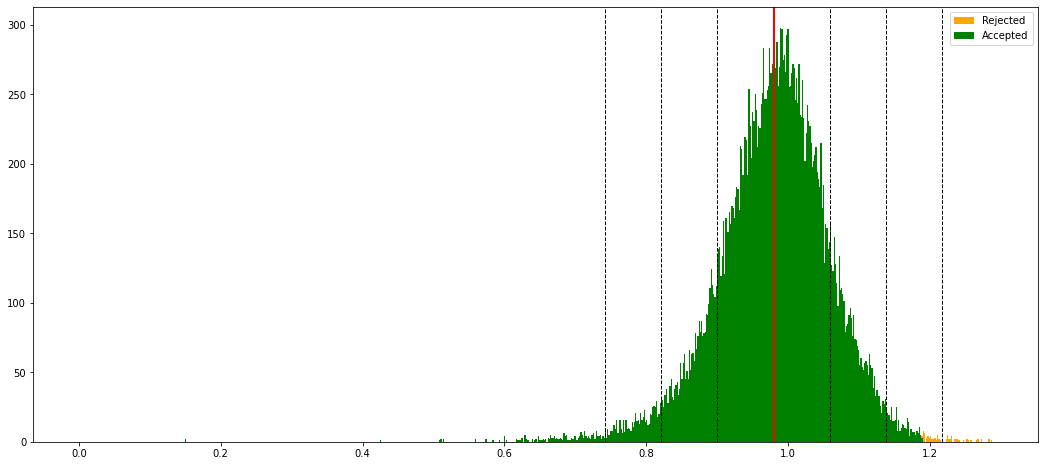

In [60]:
plot_df = dist_df
plot_df = dist_df[(dist_df['Source_Class'] == cls)]

plt.figure()

binval = 750

if len(dt) == 0:
    plot_df.Distance.hist(color='orange', bins=binval, alpha=1.0, figsize=(18, 8), label='Rejected')
else:
    all = plot_df
    # all = plot_df[(plot_df['Distance'] > max(dt))]
    pos = plot_df[(plot_df['Distance'] <= max(dt))]

    max_all = all['Distance'].max()

    all.Distance.hist(grid=False, color='orange', bins=binval, alpha=1.0, figsize=(18, 8), range=[0, max_all], label='Rejected')
    pos.Distance.hist(grid=False, color='green', bins=binval, alpha=1.0, figsize=(18, 8), range=[0, max_all], label='Accepted')

for i in range(4):
    plt.axvline(stat[1]+(stat[0]*i), linewidth=1, color='black', linestyle='dashed')
    plt.axvline(stat[1]-(stat[0]*i), linewidth=1, color='black', linestyle='dashed')

plt.axvline(stat[1], linewidth=2, color='red')

plt.legend()

# plot_df.Distance.hist(color='orange', bins=125, alpha=1.0, figsize=(18, 8))
# plot_df.Distance.hist(by=plot_df.Source_Class, color='orange', bins=125, alpha=1.0, figsize=(18, 12))
# plot_df.groupby('Source_Class').Distance.hist(bins=125, alpha=0.8, figsize=(18, 12))

## 4.2. Using Benchmarks

In [61]:
if var1 == 'Place': source_col = 'Country'
if var1 == 'Year': source_col = 'Year'
if var1 == 'Reason': source_col1 = 'Disaster_Type'
if var1 == 'Reason': source_col2 = 'Disaster_Subtype'
if var1 == 'Reason': source_col2 = 'Disaster_Subtype'

if var2 == 'Place': target_col = 'Country'
if var2 == 'Year': target_col = 'Year'
if var2 == 'Reason': target_col1 = 'Disaster_Type'
if var2 == 'Reason': target_col2 = 'Disaster_Subtype'

In [62]:
def sql_return(source_col, target_col, rand_class):
    tempDF = pd.read_sql(f'''SELECT {source_col}, COUNT(Dis_No) AS Freq
                            FROM Hum_Hist
                            WHERE {target_col} LIKE "%{rand_class}%"
                            GROUP BY {source_col}
                            ORDER BY Freq Desc''', conn)
    return tempDF

In [63]:
freq_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are:\n'

OneDF = sql_return(source_col1, target_col, rand_class)

pd.options.display.max_colwidth = 0

print(freq_title)

OneDF

Nearest Reason(s) to Place [Sudan] are:



,Disaster_Type,Freq
0,Flood,36
1,Epidemic,35
2,Drought,6
3,Severe Local Storm,2
4,Heat Wave,1
5,Insect infestation,1
6,Wild Fire,1


In [64]:
freq_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are:\n'

TwoDF = sql_return(source_col2, target_col, rand_class)

pd.options.display.max_colwidth = 0

print(freq_title)

TwoDF

Nearest Reason(s) to Place [Sudan] are:



,Disaster_Subtype,Freq
0,Riverine flood,30
1,Bacterial disease,23
2,None,8
3,Drought,6
4,Viral disease,6
5,Flash flood,3
6,Convective storm,2
7,Heat wave,1
8,"Land fire (Brush, Bush, Pasture)",1
9,Locust,1


In [65]:
inf = []
pre = []

for e in acc_ent:
    x = e.split()
    new = 0
    for y in x:
        if OneDF[source_col1].str.contains(y).any() or TwoDF[source_col2].str.contains(y).any():
            new = 1
        # else:
        #     new = 0

    if new == 1:
        inf.append(e)
    else:
        pre.append(e)

print(freq_title)
print('All Matched: ', inf)
print('Not Matched: ', pre)
print('')

Nearest Reason(s) to Place [Sudan] are:

All Matched:  ['Flash Flood', 'Flood']
Not Matched:  []



## 4.3. Clustering the Results

In [66]:
# from sklearn.cluster import KMeans

In [67]:
# ent_vec = []

# for e in en:
#     rec = class_df.loc[class_df['Entity'] == e]
#     ent_vec.append(rec['Vector'].tolist()[0])

In [68]:
# kmeans = KMeans(n_clusters=2, random_state=0).fit(ent_vec)
# clust = kmeans.labels_
# # kmeans.cluster_centers_ 
# # USE THIS FUNCTION

In [69]:
# clust

In [70]:
# rel = []
# irr = []

# for idx, e in enumerate(acc_ent):
#     if clust[idx] == clust[0]:
#         rel.append(e)
#     else:
#         irr.append(e)

# print(freq_title)
# print('Most Relevant:  ', rel)
# print('Least Relevant: ', irr)
# print('')

## 4.4. Export Results

In [71]:
def SM_Reasons(plc):
    var1, var2 = 'Reason', 'Place'

    rand_class = plc

    ents = nearest_class(var1, var2, rand_class, num_ent)

    accepted_list = ''
    rejected_list = ''

    acc_ent = []
    rej_ent = []

    en, dt, sd, me = [], [], [], []

    # cls = '*'
    cls = var1

    # alpha = -1.0

    stat = find_stat(cls)

    for ent in ents:
        if ent[1] in unwanted_list:
            continue
        rank = find_rank(cls, ent[0], alpha)
        # if rank == 'Accepted':
        en.append(ent[1])
        dt.append(ent[0])
        sd.append(stat[0])
        me.append(stat[1])
        d = round(ent[0], 4)
        z = round((ent[0] - stat[1]) / stat[0], 4)
        if rank == 'Accepted':
            accepted_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
            acc_ent.append(ent[1])
        else:
            rejected_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
            rej_ent.append(ent[1])
        # nearest_list += f'{ent[1]} ({z}); '
        # nearest_list += f'{ent[1]} ({d}); \n'

    # nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'
    nearest_title = f'Nearest {var1}(s) to {var2} [{rand_class}] are {len(en)}:\n'
    return acc_ent, rej_ent

In [72]:
# def SM_Reasons(plc):
#     var1, var2 = 'Reason', 'Place'

#     rand_class = plc

#     acc_ent = nearest_class(var1, var2, rand_class, num_ent)
#     rej_ent = farest_class(var1, var2, rand_class, num_ent)

#     acc_ent = [e for (d, e) in acc_ent]
#     rej_ent = [e for (d, e) in rej_ent]

#     return acc_ent, rej_ent

In [73]:
def EM_Reasons(plc, results):

    accepted, rejected = results[0], results[1]

    tp = []
    fp = []

    tn = []
    fn = []

    OneDF = sql_return(source_col1, target_col, plc)
    twoDF = sql_return(source_col2, target_col, plc)

    if len(OneDF) + len(twoDF) >= 1:

        for e in accepted:
            x = e.split()
            new = 0
            for y in x:
                if OneDF[source_col1].str.contains(y).any() or TwoDF[source_col2].str.contains(y).any():
                    new = 1
                # else:
                #     new = 0

            if new == 1:
                tp.append(e)
            else:
                fp.append(e)

        for e in rejected:
            x = e.split()
            new = 0
            for y in x:
                if OneDF[source_col1].str.contains(y).any() or TwoDF[source_col2].str.contains(y).any():
                    new = 1
                # else:
                #     new = 0

            if new != 1:
                tn.append(e)
            else:
                fn.append(e)

    return tp, fp, tn, fn

In [74]:
plc = labPlace_tok.classes_[random.randint(0, len(labPlace_tok.classes_)-1)]
plc = 'Sudan'

SM_RE = SM_Reasons(plc)
EM_RE = EM_Reasons(plc, SM_RE)

if len(SM_RE[0]) > 0:
    temp_tp = round(len(EM_RE[0]) / len(SM_RE[0]) * 100, 2)
    temp_fp = round(len(EM_RE[1]) / len(SM_RE[0]) * 100, 2)
else:
    temp_tp = 0.00
    temp_fp = 0.00

if len(SM_RE[1]) > 0:
    temp_tn = round(len(EM_RE[2]) / len(SM_RE[1]) * 100, 2)
    temp_fn = round(len(EM_RE[3]) / len(SM_RE[1]) * 100, 2)
else:
    temp_tn = 0.00
    temp_fn = 0.00

print(plc, f'Positive {SM_RE[0]}') 
print(plc, f'Negative {SM_RE[1]}', '\n')

print(f'True Positive  ({temp_tp}%)\t', EM_RE[0])
print(f'False Positive ({temp_fp}%)\t', EM_RE[1])
print('\r')
print(f'True Negative  ({temp_tn}%)\t', EM_RE[2])
print(f'False Negative ({temp_fn}%)\t', EM_RE[3])

Sudan Positive ['Flash Flood', 'Flood']
Sudan Negative ['Insect Infestation', 'Epidemic', 'Wild Fire', 'Drought', 'Earthquake', 'Storm Surge', 'Fire', 'Extratropical Cyclone', 'Tsunami', 'Tropical Cyclone', 'Severe Local Storm', 'Snow Avalanche', 'Heat Wave', 'Cold Wave', 'Land Slide', 'Mud Slide', 'Volcano'] 

True Positive  (100.0%)	 ['Flash Flood', 'Flood']
False Positive (0.0%)	 []

True Negative  (41.18%)	 ['Earthquake', 'Extratropical Cyclone', 'Tsunami', 'Tropical Cyclone', 'Snow Avalanche', 'Mud Slide', 'Volcano']
False Negative (58.82%)	 ['Insect Infestation', 'Epidemic', 'Wild Fire', 'Drought', 'Storm Surge', 'Fire', 'Severe Local Storm', 'Heat Wave', 'Cold Wave', 'Land Slide']


In [75]:
val_result = f'./Outputs/{model_name}Validated_Results_EM_DAT_Alpha_{alpha}.csv'

In [76]:
country = []

true_positive = []
false_positive = []

true_negative = []
false_negative = []

tp = []
fp = []

tn = []
fn = []

if os.path.isfile(val_result):
    resultDF = pd.read_csv(val_result)
else:
    for plc in labPlace_tok.classes_:
        SM_RE = SM_Reasons(plc)
        EM_RE = EM_Reasons(plc, SM_RE)

        # if plc == 'Sudan':
        #     print(EM_RE)

        # if len(EM_RE[0])+len(EM_RE[1]) == 0:
        #     continue

        # if len(SM_RE[0]) > 0:
        temp_tp = len(EM_RE[0])
        temp_fp = len(EM_RE[1])
        # else:
        #     continue

        # if len(EM_RE[2])+len(EM_RE[3]) == 0:
        #     continue

        # if len(SM_RE[1]) > 0:
        temp_tn = len(EM_RE[2])
        temp_fn = len(EM_RE[3])
        # else:
        #     continue

        country.append(plc)

        true_positive.append(EM_RE[0])
        false_positive.append(EM_RE[1])
        true_negative.append(EM_RE[2])
        false_negative.append(EM_RE[3])

        tp.append(temp_tp)
        fp.append(temp_fp)
        tn.append(temp_tn)
        fn.append(temp_fn)

    resultDict = {'Country': country, 'True Positive': true_positive, 'False Positive': false_positive, 'True Negative': true_negative, 'False Negative': false_negative, 'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn}
    resultDF = pd.DataFrame(data=resultDict)
    resultDF.to_csv(val_result)

In [77]:
TP = resultDF['TP'].sum()
FP = resultDF['FP'].sum()
TN = resultDF['TN'].sum()
FN = resultDF['FN'].sum()

In [78]:
Accuracy = ((TP+TN) / (TP+FP+FN+TN))
Precision = (TP / (TP+FP))
Recall = (TP / (TP+FN))
F1_Score = 2*(Recall * Precision) / (Recall + Precision)

In [79]:
Accuracy = round(Accuracy * 100, 2)
Precision = round(Precision * 100, 2)
Recall = round(Recall * 100, 2)
F1_Score = round(F1_Score * 100, 2)

In [80]:
print(f'Accuracy \t: {Accuracy} %')
print(f'Precision \t: {Precision} %')
print(f'Recall \t\t: {Recall} %')
print(f'F1 Score \t: {F1_Score} %')

Accuracy 	: 51.85 %
Precision 	: 74.11 %
Recall 		: 14.2 %
F1 Score 	: 23.83 %


# 5. SDG Validation

source: https://dashboards.sdgindex.org/downloads

In [81]:
sdg_conn = connect(':memory:')

In [82]:
sdgFile = './Inputs/SDR_2021_Database.csv'
sdgDF = pd.read_csv(sdgFile)

In [83]:
sdgDF.to_sql('SDG_Hist', sdg_conn)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [84]:
list_country = sdgDF['Country'].unique()

In [85]:
def sdg_return(source_col, target_col, rand_class):
    tempDF = pd.read_sql(f'''SELECT {source_col}
                            FROM SDG_Hist
                            WHERE {target_col} LIKE "%{rand_class}%"''', sdg_conn)
    
    if len(tempDF[source_col]) >= 1:
        flag = tempDF[source_col][0]
    else:
        flag = ''

    return flag

In [86]:
def check_SDG(SE_SDG):
    if SE_SDG == 'No Poverty': source_col3 = 'Goal_1'
    if SE_SDG == 'Zero Hunger': source_col3 = 'Goal_2'
    if SE_SDG == 'Good Health and Well-being': source_col3 = 'Goal_3'
    if SE_SDG == 'Quality Education': source_col3 = 'Goal_4'
    if SE_SDG == 'Gender Equality': source_col3 = 'Goal_5'
    if SE_SDG == 'Clean Water and Sanitation': source_col3 = 'Goal_6'
    if SE_SDG == 'Affordable and Clean Energy': source_col3 = 'Goal_7'
    if SE_SDG == 'Decent Work and Economic Growth': source_col3 = 'Goal_8'
    if SE_SDG == 'Industry Innovation and Infrastructure': source_col3 = 'Goal_9'
    if SE_SDG == 'Reducing Inequality': source_col3 = 'Goal_10'
    if SE_SDG == 'Sustainable Cities and Communities': source_col3 = 'Goal_11'
    if SE_SDG == 'Responsible Consumption and Production': source_col3 = 'Goal_12'
    if SE_SDG == 'Climate Action': source_col3 = 'Goal_13'
    if SE_SDG == 'Life Below Water': source_col3 = 'Goal_14'
    if SE_SDG == 'Life On Land': source_col3 = 'Goal_15'
    if SE_SDG == 'Peace Justice and Strong Institutions': source_col3 = 'Goal_16'
    if SE_SDG == 'Partnerships for the Goals': source_col3 = 'Goal_17'   

    return source_col3

In [87]:
def SM_Goals(plc):
    var1, var2 = 'Goal', 'Place'

    rand_class = plc

    ents = nearest_class(var1, var2, rand_class, 1)

    accepted_list = ''
    rejected_list = ''

    acc_ent = []

    en, dt, sd, me = [], [], [], []

    # cls = '*'
    cls = var1

    # alpha = -1.0

    stat = find_stat(cls)

    for ent in ents:
        rank = find_rank(cls, ent[0], alpha)
        en.append(ent[1])
        dt.append(ent[0])
        sd.append(stat[0])
        me.append(stat[1])
        d = round(ent[0], 4)
        z = round((ent[0] - stat[1]) / stat[0], 4)
        # if rank == 'Accepted':
        accepted_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'
        acc_ent.append(ent[1])
        # else:
        #     rejected_list += f'{ent[1]} [Distance={d}, Z-Score={z}] -- [{rank}];\n'

    return acc_ent

In [88]:
def SD_Goals(plc, SM_GO):

    tp = []
    fp = []

    for e in SM_GO:
        source_col3 = check_SDG(e)
        SDG_Flag = sdg_return(source_col3, target_col, plc)
        # print(SDG_Flag)
        if SDG_Flag == 'red' or SDG_Flag == 'orange' or SDG_Flag == 'yellow':
        # if SDG_Flag == 'red' or SDG_Flag == 'orange':
            tp.append(e)
        else:
            fp.append(e)

    return tp, fp

In [89]:
plc = labPlace_tok.classes_[random.randint(0, len(labPlace_tok.classes_)-1)]
plc = 'Guam'

SM_RE = SM_Goals(plc)
EM_RE = SD_Goals(plc, SM_RE)

if len(SM_RE) > 0:
    SM_PR = round(len(EM_RE[0]) / len(SM_RE) * 100, 2)
    EM_PR = round(len(EM_RE[1]) / len(SM_RE) * 100, 2)
else:
    SM_PR = 0.00
    EM_PR = 0.00

print(plc, SM_RE, '\n')
print(f'True Positive  ({SM_PR}%)\t', EM_RE[0])
print(f'False Positive ({EM_PR}%)\t', EM_RE[1])

Guam ['Good Health and Well-being'] 

True Positive  (0.0%)	 []
False Positive (100.0%)	 ['Good Health and Well-being']


In [90]:
sdg_result = f'./Outputs/{model_name}Validated_SDG_Result_SDR.csv'

In [91]:
country = []

true_positive = []
false_positive = []
tp_percent = []
fp_percent = []

if os.path.isfile(sdg_result):
    sdgEvDF = pd.read_csv(sdg_result)
else:
    for plc in labPlace_tok.classes_:
        
        if plc not in list_country: continue

        SM_RE = SM_Goals(plc)
        EM_RE = SD_Goals(plc, SM_RE)

        if len(SM_RE) > 0:
            SM_PR = round(len(EM_RE[0]) / len(SM_RE) * 100, 2)
            EM_PR = round(len(EM_RE[1]) / len(SM_RE) * 100, 2)
        else:
            SM_PR = 0.00
            EM_PR = 0.00

        # if plc == 'Sudan':
        #     print(EM_RE)

        if len(EM_RE[0])+len(EM_RE[1]) == 0:
            continue

        if len(SM_RE) > 0:
            SM_PR = len(EM_RE[0]) / len(SM_RE)
            EM_PR = len(EM_RE[1]) / len(SM_RE)
        else:
            continue

        country.append(plc)
        true_positive.append(EM_RE[0])
        false_positive.append(EM_RE[1])
        tp_percent.append(SM_PR)
        fp_percent.append(EM_PR)

    sdgEvDc = {'Country': country, 'True Positive': true_positive, 'False Positive': false_positive, 'TP Percent': tp_percent, 'FP Percent': fp_percent}
    sdgEvDF = pd.DataFrame(data=sdgEvDc)
    sdgEvDF.to_csv(sdg_result)

In [92]:
avg_true = round(sdgEvDF['TP Percent'].mean() * 100, 2)
avg_false = round(sdgEvDF['FP Percent'].mean() * 100, 2)

print(f'Average True Positive : {avg_true} %')
print(f'Average False Positive : {avg_false} %')

Average True Positive : 91.89 %
Average False Positive : 8.11 %
